In [ ]:
#Importing libraries.

import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression #main
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, accuracy_score
from sklearn.isotonic import IsotonicRegression
from mpl_toolkits.mplot3d import Axes3D
from xgboost import XGBClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

# **Notebook Summary**

**Preprocessing and Model:**
1.   40 legit subscribers statistical units + 39 fraud-detected subscribers statistical units (1 fraud-detected statistical unit was missing important features, hence was excluded from the input dataset; its ws_id: "6511c2eca961d760fd6a5506").
2.   Categorical inputs: email {1:["gmail.com","yahoo.com","outlook.com","yandex.com"], 0: [else - business emails]}, CAKE_AG account 1 else 0, label encoder was used for countries.
3.   Logistic Regression for binary classification + DecisionTree for the tree graph + RandomForest for features importance + cumulative feature importance.
**Findings:**
1.   Pierson's correlation coefficient showed a couple of inputs with a moderate correlation with the target variable ("fraud"): logins (-0.66), CAKE_AG (+0.64), email (+0.58), days to purchase (-0.38), and country (-0.34).
2.   DecisionTree built on the entropy loss shows that the number of logins is the perfect split variable between fraud and legit users. If a user has < 2.5 logins, s/he is a fraud. Also, if a user has more than 2.5 logs, but also has a country code > 17.5, s/he is a fraud.
3.   After the LogReg model was built, it was validated on unseen data: 9 legit + 7 fraud subscribers (16 stat.units in total). It predicted 7 true positives, 8 true negatives, and 1 false positive fraud.
4.   The model's coefficients showed the impact on log(odds) with a change in 1 unit in the given feature: logins(-1.85), country (-1.48), email (+1.28), days_to_purchase (-1.08), CAKE_AG (+1.03).
5.   The model's predicted odds were especially strong for the following features: logins (0.15), email (3.58), and CAKE_AG (2.79). Odds that are around 1 are not that strong. Odds that are much lower than 0 indicate strong negative impact on a given event (move in different directions). Odds that are much higher than 1 indicate strong positive impact on a given event (move in the same direction).
6.   Predicted probabilities are very well calibrated to true probabilities.
7.   Logins, email, country, CAKE_AG, and days to purchase make ~90% of total feature importance.
8.   All three models (LogReg, DecisionTree, and ensemble RandomForest) select the same group of features as important prediction inputs.

In [ ]:
#Uploading dataset.

data = pd.read_csv("/content/fraud.csv")

In [ ]:
#EDA.

data.head()

,workspace_id,country,creation_date,first_invoice_date,project_creation,add_client,export_report,integrations,connect_calendar,add_delete_tag,...,time_entries_calendar,time_entries_timesheet,add_filter,publish_schedule,invited_users,spam_,days_to_purchase,email,account,logins
0,64e25661b672241026f470a9,Mozambique,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,aprabhu@aries.co.mz,CAKE_AG,71.0
1,64e247798efa895570aaa70b,United States,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,spartanhubbardgroup.com,CAKE_INC,19.0
2,64e248948efa895570aaadd5,United States,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,southersalts1@gmail.com,CAKE_INC,12.0
3,64e21976b672241026f2f207,United States,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,me.com,CAKE_INC,47.0
4,64e1dde620b08b6c2ef7d996,Sweden,8/21/2023,8/21/2023,0,0,0,0,0,0,...,0,0,0,0,0,0,0,jonas.kallin@swedwise.se,CAKE_AG,2.0


In [ ]:
#EDA, checking if the missing country and missing email belong to the same ws_id and is it the fraud labeled ws_id.

data[(pd.isna(data['email'])) & (pd.isna(data['country'])) & (data['spam_']==1)]['workspace_id'] #yes, thus we will delete it.

36    6511c2eca961d760fd6a5506
Name: workspace_id, dtype: object

In [ ]:
#EDA.
data.dropna(inplace=True)
data.isnull().sum()

workspace_id              0
country                   0
creation_date             0
first_invoice_date        0
project_creation          0
add_client                0
export_report             0
integrations              0
connect_calendar          0
add_delete_tag            0
trial_activation          0
import_csv                0
time_off                  0
create_invoice            0
timesheet_approvals       0
lock_entries              0
add_targets               0
connect_quickbooks        0
create_expense            0
project_budget            0
time_entries_tracker      0
add_new_member            0
gps_tracking              0
screenshot_capturing      0
create_custom_field       0
activate_audit_log        0
time_entries_calendar     0
time_entries_timesheet    0
add_filter                0
publish_schedule          0
invited_users             0
spam_                     0
days_to_purchase          0
email                     0
account                   0
logins              

In [ ]:
#Preprocessing: Encoding categorical features.

categorical_ = data.select_dtypes(exclude=np.int)
print(categorical_.columns)

Index(['workspace_id', 'country', 'creation_date', 'first_invoice_date',
       'email', 'account', 'logins'],
      dtype='object')


<ipython-input-6-4fc14114cd02>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_ = data.select_dtypes(exclude=np.int)


In [ ]:
#Preprocessing: Encoding categorical features.

data["country_encoded"] = LabelEncoder().fit_transform(data["country"])

In [ ]:
#Preprocessing: Encoding categorical features.

data = pd.concat([data, pd.get_dummies(data["account"])],axis=1)
data.head()

,workspace_id,country,creation_date,first_invoice_date,project_creation,add_client,export_report,integrations,connect_calendar,add_delete_tag,...,publish_schedule,invited_users,spam_,days_to_purchase,email,account,logins,country_encoded,CAKE_AG,CAKE_INC
0,64e25661b672241026f470a9,Mozambique,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,aprabhu@aries.co.mz,CAKE_AG,71.0,10,1,0
1,64e247798efa895570aaa70b,United States,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,spartanhubbardgroup.com,CAKE_INC,19.0,17,0,1
2,64e248948efa895570aaadd5,United States,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,southersalts1@gmail.com,CAKE_INC,12.0,17,0,1
3,64e21976b672241026f2f207,United States,8/20/2023,8/20/2023,0,0,0,0,0,0,...,0,0,0,0,me.com,CAKE_INC,47.0,17,0,1
4,64e1dde620b08b6c2ef7d996,Sweden,8/21/2023,8/21/2023,0,0,0,0,0,0,...,0,0,0,0,jonas.kallin@swedwise.se,CAKE_AG,2.0,13,1,0


In [ ]:
#Preprocessing: Encoding categorical features.

data['encoded_email'] = data['email'].str.split("@").str[-1].apply(lambda x: 1 if x in ['gmail.com', 'yahoo.com', 'outlook.com','yandex.com'] else 0)

In [ ]:
#Preparing a working data set.

df = data.copy()
df.drop(["workspace_id","country","email","account","CAKE_INC","creation_date","first_invoice_date"],axis=1,inplace=True)

In [ ]:
#WDS.

df.describe().round(2).drop(["25%","50%"])

,project_creation,add_client,export_report,integrations,connect_calendar,add_delete_tag,trial_activation,import_csv,time_off,create_invoice,...,time_entries_timesheet,add_filter,publish_schedule,invited_users,spam_,days_to_purchase,logins,country_encoded,CAKE_AG,encoded_email
count,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.0,79.0,79.0,...,79.00,79.00,79.0,79.00,79.00,79.00,79.00,79.00,79.00,79.00
mean,1.16,0.10,0.04,0.01,0.05,0.14,0.06,0.0,0.0,0.0,...,14.70,0.85,0.0,0.33,0.49,4.61,32.75,9.08,0.67,0.67
std,5.38,0.44,0.25,0.11,0.32,0.69,0.25,0.0,0.0,0.0,...,98.42,5.05,0.0,1.06,0.50,11.90,58.31,7.34,0.47,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,0.0,0.00,1.00,0.00,37.50,17.00,1.00,1.00
max,42.00,3.00,2.00,1.00,2.00,5.00,1.00,0.0,0.0,0.0,...,844.00,44.00,0.0,5.00,1.00,62.00,354.00,18.00,1.00,1.00


In [ ]:
#Rescaling data.

stats = df.describe()

non_zero_std_columns = stats.loc['std'] != 0

df = df.loc[:, non_zero_std_columns]


X = df.drop("spam_",axis=1)
y = df.spam_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train_std = (X_train - X_train.mean())/(X_train.std())
X_test_std = (X_test - X_train.mean())/(X_train.std())

X_train_std.dropna(axis=1, inplace=True)
X_test_std.dropna(axis=1, inplace=True)

In [ ]:
X_train_std.shape

(63, 21)

In [ ]:
# Correlation.

correlation = df.corr().loc['spam_', :].sort_values(ascending=False).dropna()
correlation.sort_values(ascending=False)

spam_                     1.000000
CAKE_AG                   0.637712
encoded_email             0.583831
integrations              0.114670
timesheet_approvals      -0.111803
create_custom_field      -0.111803
screenshot_capturing     -0.111803
time_entries_tracker     -0.116370
time_entries_timesheet   -0.148383
lock_entries             -0.150775
export_report            -0.150775
trial_activation         -0.152684
connect_calendar         -0.159137
add_filter               -0.166763
project_budget           -0.172261
time_entries_calendar    -0.199626
add_delete_tag           -0.199641
project_creation         -0.210218
add_client               -0.228035
add_new_member           -0.308887
invited_users            -0.308887
country_encoded          -0.343325
days_to_purchase         -0.384813
logins                   -0.505674
Name: spam_, dtype: float64

In [ ]:
#Checking the nodes structure.

dec_tree_ = DecisionTreeClassifier(max_depth=3, criterion="entropy").fit(X,y)

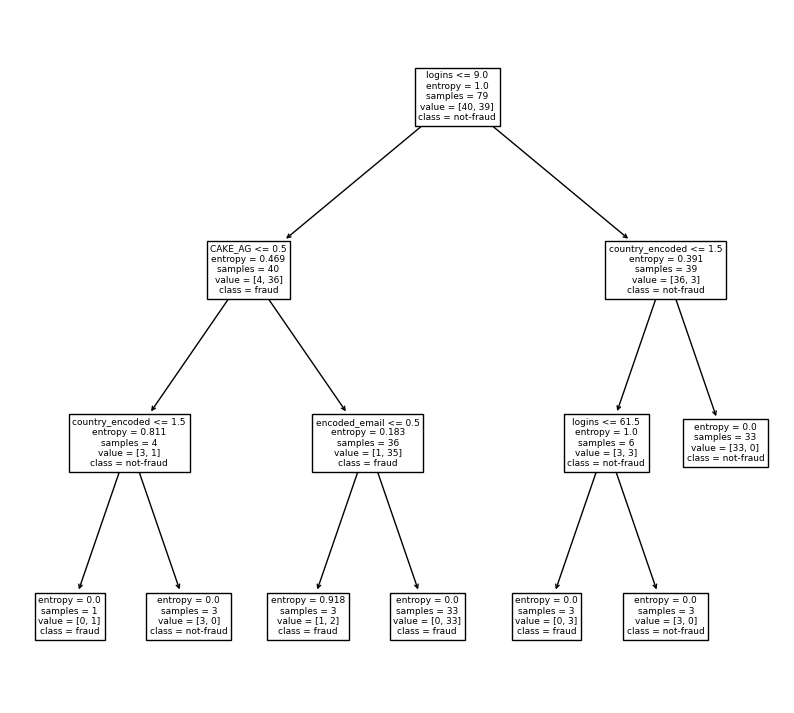

In [ ]:
#Viz nodes.

fig,ax = plt.subplots(figsize=(10,9))
ax = plot_tree(dec_tree_, feature_names=X.columns, class_names=["not-fraud","fraud"])
fig.savefig("dec_tree.png")

In [ ]:
#Training RandomForestClassifier model.

rfc = RandomForestClassifier(class_weight="balanced",max_depth=4,criterion="gini").fit(X_train,y_train)

In [ ]:
#Predicting probabilities.

proba = rfc.predict_proba(X_test)[:,1]

In [ ]:
#Calibrating probabilities.

print(f"Mean predicted p: ", np.mean(proba))
print(f"Mean p: ", np.mean(y_test))

Mean predicted p:  0.5877937564308062
Mean p:  0.5


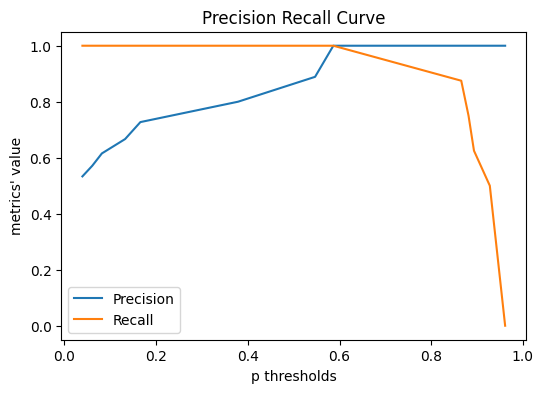

In [ ]:
#Checking performance possibilities.

precision, recall, thresholds = precision_recall_curve(y_test,proba)

plt.figure(figsize=(6,4))
plt.plot(thresholds,precision[1:],label="Precision")
plt.plot(thresholds,recall[1:],label="Recall")
plt.title("Precision Recall Curve")
plt.xlabel("p thresholds")
plt.ylabel("metrics' value")
plt.legend(loc="lower left")
plt.show()

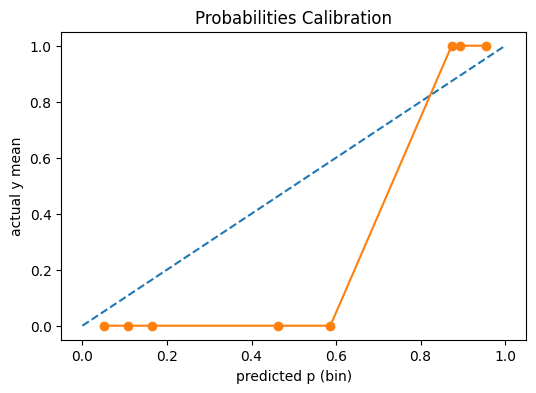

In [ ]:
#Calibration curve.

y_means, proba_means = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,4))
plt.plot([0,1],[0,1],linestyle='--',label="Perfect Calibration")
plt.plot(proba_means,y_means,"-o")
plt.title("Probabilities Calibration")
plt.xlabel("predicted p (bin)")
plt.ylabel("actual y mean")
plt.show()

In [ ]:
#Building the calibrator.

iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(proba, y_test)

In [ ]:
#Predicting with calibrator.

probs_ = iso_reg.predict(rfc.predict_proba(X_test)[:, 1])

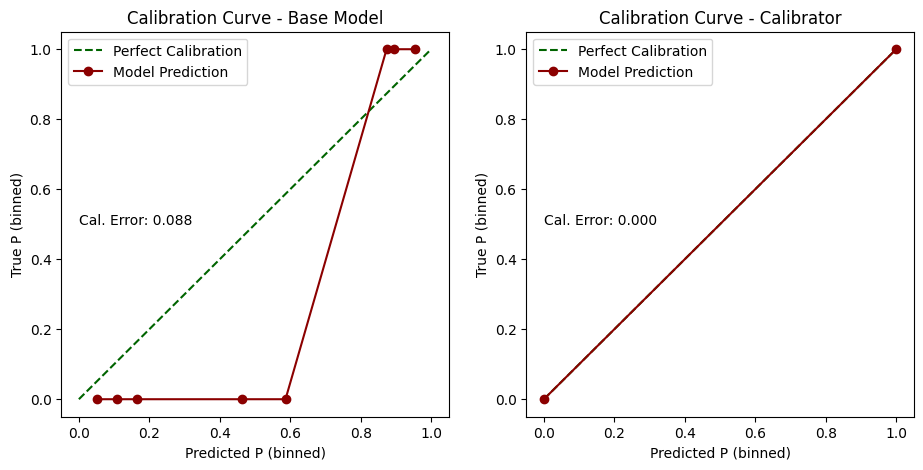

In [ ]:
#Calibration curves.

def expected_calibration_error(y, proba, bins='fd'):
    bin_count, bin_edges = np.histogram(proba, bins=bins)
    n_bins = len(bin_count)

    bin_id = np.digitize(proba, bin_edges, right=True) - 1
    bin_id = np.clip(bin_id, 0, n_bins - 1)

    bin_ysum = np.bincount(bin_id, weights=y, minlength=n_bins)
    bin_probasum = np.bincount(bin_id, weights=proba, minlength=n_bins)

    bin_ymean = np.divide(bin_ysum, bin_count, out=np.zeros(n_bins), where=bin_count > 0)
    bin_probamean = np.divide(bin_probasum, bin_count, out=np.zeros(n_bins), where=bin_count > 0)

    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)

    return ece


y_m, proba_m = calibration_curve(y_test, probs_, n_bins=10, strategy="quantile")

figures, axes = plt.subplots(1,2,figsize=(11,5))

base_model = expected_calibration_error(y_test, proba, bins = 'fd')
calibrator = expected_calibration_error(y_test, probs_, bins = 'fd')

axes[0].plot([0,1],[0,1],linestyle='--',label="Perfect Calibration", c="darkgreen")
axes[0].plot(proba_means,y_means,"-o", label="Model Prediction",c="darkred")
axes[0].set_title("Calibration Curve - Base Model", color="black")
axes[0].set_xlabel("Predicted P (binned)", color="black")
axes[0].set_ylabel("True P (binned)", color="black")
axes[0].legend(loc="best")
axes[0].annotate(f"Cal. Error: {base_model:.3f}",
                 xy=(0.5,0.5),
                 xytext=(0.0, 0.5),
                 color='black',
                )

axes[1].plot([0,1],[0,1],linestyle='--',label="Perfect Calibration",c="darkgreen")
axes[1].plot(proba_m,y_m,"-o", label="Model Prediction",c="darkred")
axes[1].set_title("Calibration Curve - Calibrator",color="black")
axes[1].set_xlabel("Predicted P (binned)", color="black")
axes[1].set_ylabel("True P (binned)", color="black")
axes[1].legend(loc="best")
axes[1].annotate(f"Cal. Error: {calibrator:.3f}",
                 xy=(0.5,0.5),
                 xytext=(0.0, 0.5),
                 color='black',
                )

plt.savefig("calibration_error.png")
plt.show()

In [ ]:
#Validating model's performance.

y_pred = iso_reg.predict(rfc.predict(X_test))

probabilities = (iso_reg.predict(rfc.predict_proba(X_test)[:,1]) > 0.6).astype(int)

print(classification_report(y_test,probabilities))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [ ]:
# @title
#Defining the function.

def expected_calibration_error(y, proba, bins = 'fd'):
  bin_count, bin_edges = np.histogram(proba, bins = bins)
  n_bins = len(bin_count)
  bin_edges[0] -= 1e-8
  bin_id = np.digitize(proba, bin_edges, right = True) - 1
  bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
  bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
  bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
  ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
  return ece

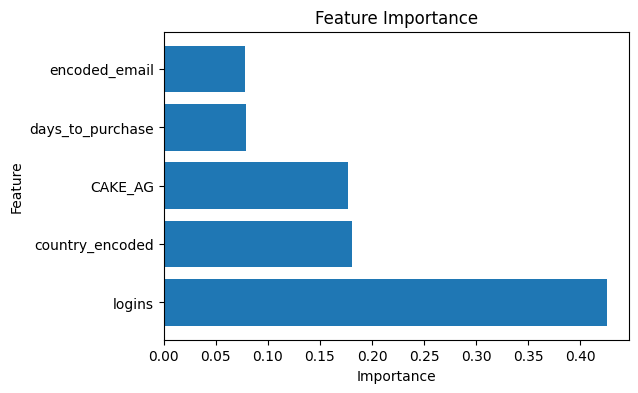

In [ ]:
#Exploring features importance.

feature_importances = rfc.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)
importance_df_rf['Cumulative Importance'] = importance_df_rf['Importance'].cumsum()
important_features_df = importance_df_rf[importance_df_rf['Importance'] > 0.02]
figure2 = plt.figure(figsize=(6, 4))
plt.barh(important_features_df['Feature'], important_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig("feature_importance.png")
plt.show()

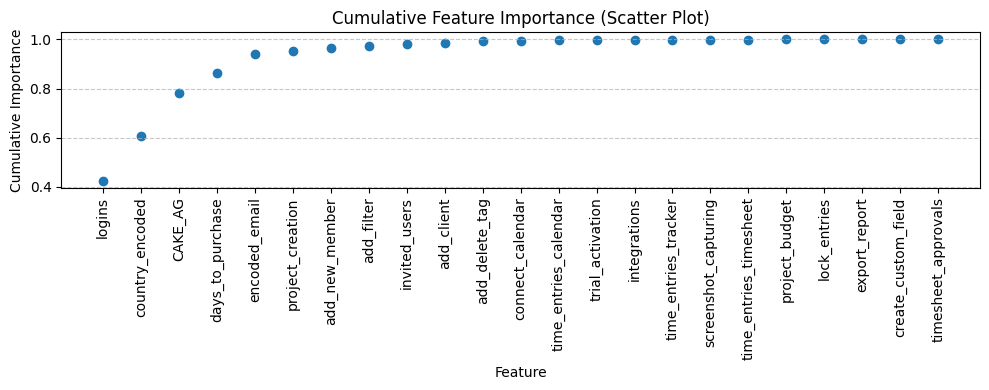

In [ ]:
#Viz cummulative features importance.

plt.figure(figsize=(10, 4))
plt.scatter(importance_df_rf['Feature'], importance_df_rf['Cumulative Importance'])
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance (Scatter Plot)')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
data_check = pd.DataFrame(data[["country","country_encoded"]].values, columns=["country","label"])

In [ ]:
data_check.to_csv("countries_labels.csv")